# Course project


## **Основное**
- Дедлайн - 31 мая 23:59
- Целевая метрика precision@5 > 0.235
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. В решении должны быть отчетливо видна метрика на новом тестовом сете из файла retail_test1.csv, то есть вам нужно для всех юзеров из этого файла выдать выши рекомендации, и посчитать на actual покупках precision@5. 

**!! Мы не рассматриваем холодный старт для пользователя, все наши пользователя одинаковы во всех сетах, поэтому нужно позаботиться об их исключении из теста.**


**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 

In [1]:
# !pip install implicit==0.4.4

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive')
!ls /content/drive/MyDrive/*.py

/content/drive/MyDrive/metrics.py	/content/drive/MyDrive/utils.py
/content/drive/MyDrive/recommenders.py


# Import libs

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Read data

In [6]:
PATH_DATA = "drive/MyDrive/"

In [7]:
data = pd.read_csv(os.path.join(PATH_DATA,'retail_train.csv'))
item_features = pd.read_csv(os.path.join(PATH_DATA,'product.csv'))
user_features = pd.read_csv(os.path.join(PATH_DATA,'hh_demographic.csv'))

# Set global const

In [8]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 70

# Process features dataset

In [9]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [10]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [11]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [12]:
# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [13]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [14]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [15]:
# выше видим разброс по пользователям и товарам и дальше мы перейдем к warm-start (только известные пользователи)

In [16]:
data_val_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


# Prefilter items

In [17]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=3000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/content/drive/MyDrive/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 3001


# Make cold-start to warm-start

In [18]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 3001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


# Init/train recommender

In [19]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [20]:
# Берем тестового юзера 2375

In [21]:
recommender.get_als_recommendations(2375, N=5)

[947858, 1138467, 1132771, 899624, 823990]

In [22]:
recommender.get_own_recommendations(2375, N=5)

[918046, 907099, 1027642, 847962, 884694]

In [23]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 999999, 962185, 1079913, 823775]

In [24]:
# recommender.get_similar_users_recommendation(2375, N=5)

# Eval recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [25]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [26]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

CPU times: user 1min 13s, sys: 43 s, total: 1min 56s
Wall time: 1min 2s


In [27]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 8.11 µs


### Пример оборачивания

In [28]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [29]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [30]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [31]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [32]:
TOPK_RECALL = 100

In [33]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.08529390656625159),
 ('als_rec', 0.08280696060503241),
 ('sim_item_rec', 0.049801795243109556)]

### Precision@5 of matching

In [34]:
TOPK_PRECISION = 5

In [35]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.1926545792654558),
 ('als_rec', 0.13714551371454992),
 ('sim_item_rec', 0.06276150627615097)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [36]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [37]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [38]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [39]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1092937, 944588, 917033, 10198378, 1..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [40]:
# разворачиваем товары
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [41]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [42]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1092937
0,2070,944588
0,2070,917033


### Check warm start

In [43]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (150570, 2) Users: 2151 Items: 2942


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [44]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [45]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [46]:
df_ranker_train.target.value_counts()

0.0    137555
1.0     10536
Name: target, dtype: int64

In [47]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1092937,1.0


(!) На каждого юзера 50 item_id-кандидатов

In [48]:
df_ranker_train['target'].mean()

0.07114544435516

1) Pointwise
2) Pairwise
3) ListWise

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

### Описательные фичи

In [49]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [50]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [51]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Поведенческие фичи

##### Чтобы считать поведенческие фичи, нужно учесть все данные что были до data_val_ranker

In [52]:
df_join_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [53]:
df_join_train_matcher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278490 entries, 0 to 2282324
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 226.0 MB


## !!! Пока выполните нотбук без этих строк, потом вернитесь и запустите их, обучите ранкер и посмотрите на метрики с ранжированием

In [54]:
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=['user_id', 'item_id']).agg('sales_value').sum().rename('total_user_sums_per_item'), how='left', on=['user_id', 'item_id'])
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=['user_id', 'item_id']).agg('sales_value').mean().rename('mean_user_sum_per_item'), how='left', on=['user_id', 'item_id'])
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=['user_id', 'item_id']).agg('sales_value').std().rename('std_user_sum_per_item'), how='left', on=['user_id', 'item_id'])

df_join_train_matcher[['abs_retail_disc', 'abs_coupon_disc', 'abs_coupon_match_disc']] = df_join_train_matcher[['retail_disc', 'coupon_disc', 'coupon_match_disc']].abs()

df_join_train_matcher['fraction_of_retail_disc_in_sales_value'] = (df_join_train_matcher['abs_retail_disc'] / df_join_train_matcher['sales_value']).round(2)
df_join_train_matcher['summary_discount'] = df_join_train_matcher[['abs_retail_disc', 'abs_coupon_disc', 'abs_coupon_match_disc']].sum(axis=1)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=['user_id', 'item_id']).agg('week_no').count().rename('number_of_purchases_in_week'), how='left', on=['user_id', 'item_id'])

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=['user_id', 'item_id']).agg('week_no').min().rename('first_active_month'), how='left', on=['user_id', 'item_id'])
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=['user_id', 'item_id']).agg('week_no').max().rename('last_active_month'), how='left', on=['user_id', 'item_id'])
df_ranker_train['diff_beetween_last_active_and_last_month'] = df_join_train_matcher['week_no'].max() - df_ranker_train['last_active_month']

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=['user_id', 'item_id']).agg('quantity').sum().rename('user_item_quantity'), how='left', on=['user_id', 'item_id'])

df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['manufacturer', 'department']).agg('target').mean().rename('manufacturer_department_target'), how='left', on=['manufacturer', 'department'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['brand', 'department']).agg('target').mean().rename('brand_department_target'), how='left', on=['brand', 'department'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['brand', 'age_desc']).agg('target').mean().rename('brand_age_desc_target'), how='left', on=['brand', 'age_desc'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['brand', 'income_desc']).agg('target').mean().rename('brand_income_desc_target'), how='left', on=['brand', 'income_desc'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['brand', 'homeowner_desc']).agg('target').mean().rename('brand_homeowner_desc_target'), how='left', on=['brand', 'homeowner_desc'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['department', 'age_desc']).agg('target').mean().rename('department_age_desc_target'), how='left', on=['department', 'age_desc'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['department', 'income_desc']).agg('target').mean().rename('department_income_desc_target'), how='left', on=['department', 'income_desc'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['department', 'homeowner_desc']).agg('target').mean().rename('department_homeowner_desc_target'), how='left', on=['department', 'homeowner_desc'])
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['department', 'household_size_desc']).agg('target').mean().rename('department_household_size_desc_target'), how='left', on=['department', 'household_size_desc'])

In [55]:
cat_feats = df_ranker_train.select_dtypes(include='object').columns
dict_code_mean = {col: pd.DataFrame() for col in cat_feats}
for col in cat_feats:
    col_name = str(col) + '_mean_group'
    dict_code_mean[col] = df_ranker_train.groupby([col], as_index=False).agg({'target':'mean'}).rename(columns={'target':col_name})
    df_ranker_train = df_ranker_train.merge(dict_code_mean[col], on=[col], how='left')

In [56]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148091 entries, 0 to 148090
Data columns (total 56 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   user_id                                   148091 non-null  int64  
 1   item_id                                   148091 non-null  int64  
 2   target                                    148091 non-null  float64
 3   manufacturer                              148091 non-null  int64  
 4   department                                148091 non-null  object 
 5   brand                                     148091 non-null  object 
 6   commodity_desc                            148091 non-null  object 
 7   sub_commodity_desc                        148091 non-null  object 
 8   curr_size_of_product                      148091 non-null  object 
 9   age_desc                                  55140 non-null   object 
 10  marital_status_code 

In [57]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,commodity_desc_mean_group,sub_commodity_desc_mean_group,curr_size_of_product_mean_group,age_desc_mean_group,marital_status_code_mean_group,income_desc_mean_group,homeowner_desc_mean_group,hh_comp_desc_mean_group,household_size_desc_mean_group,kid_category_desc_mean_group
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,0.072464,0.072464,0.060010,0.104681,0.096139,0.110944,0.085811,0.095332,0.095295,0.101195
1,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,...,0.064326,0.097315,0.087273,0.104681,0.096139,0.110944,0.085811,0.095332,0.095295,0.101195
2,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,0.064326,0.061203,0.067425,0.104681,0.096139,0.110944,0.085811,0.095332,0.095295,0.101195
3,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,0.060146,0.054997,0.067425,0.104681,0.096139,0.110944,0.085811,0.095332,0.095295,0.101195
4,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,...,0.100418,0.171429,0.160000,0.104681,0.096139,0.110944,0.085811,0.095332,0.095295,0.101195


In [58]:
cat_feats = df_ranker_train.select_dtypes(include=['int', 'float']).columns

In [59]:
X_train = df_ranker_train[cat_feats].drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [60]:
# lgb = LGBMClassifier(random_state=21)

In [61]:
# params = {'n_estimators':[100, 200, 500, 1000], 
#           'max_depth':[5, 7, 10, 15],
#           'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [62]:
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [63]:
# %%time

# rs = RandomizedSearchCV(lgb, params, scoring='precision', cv=cv, n_jobs=-1)
# rs.fit(X_train, y_train)

In [64]:
# rs.best_params_

In [65]:
# rs.best_score_

## Обучение модели ранжирования

In [66]:
%%time
lgb = LGBMClassifier(max_depth=10,
                     n_estimators=1000,
                     learning_rate=0.1,
                     n_jobs=-1)

lgb.fit(X_train, y_train.values.ravel())

CPU times: user 34.5 s, sys: 21 ms, total: 34.5 s
Wall time: 18.5 s


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


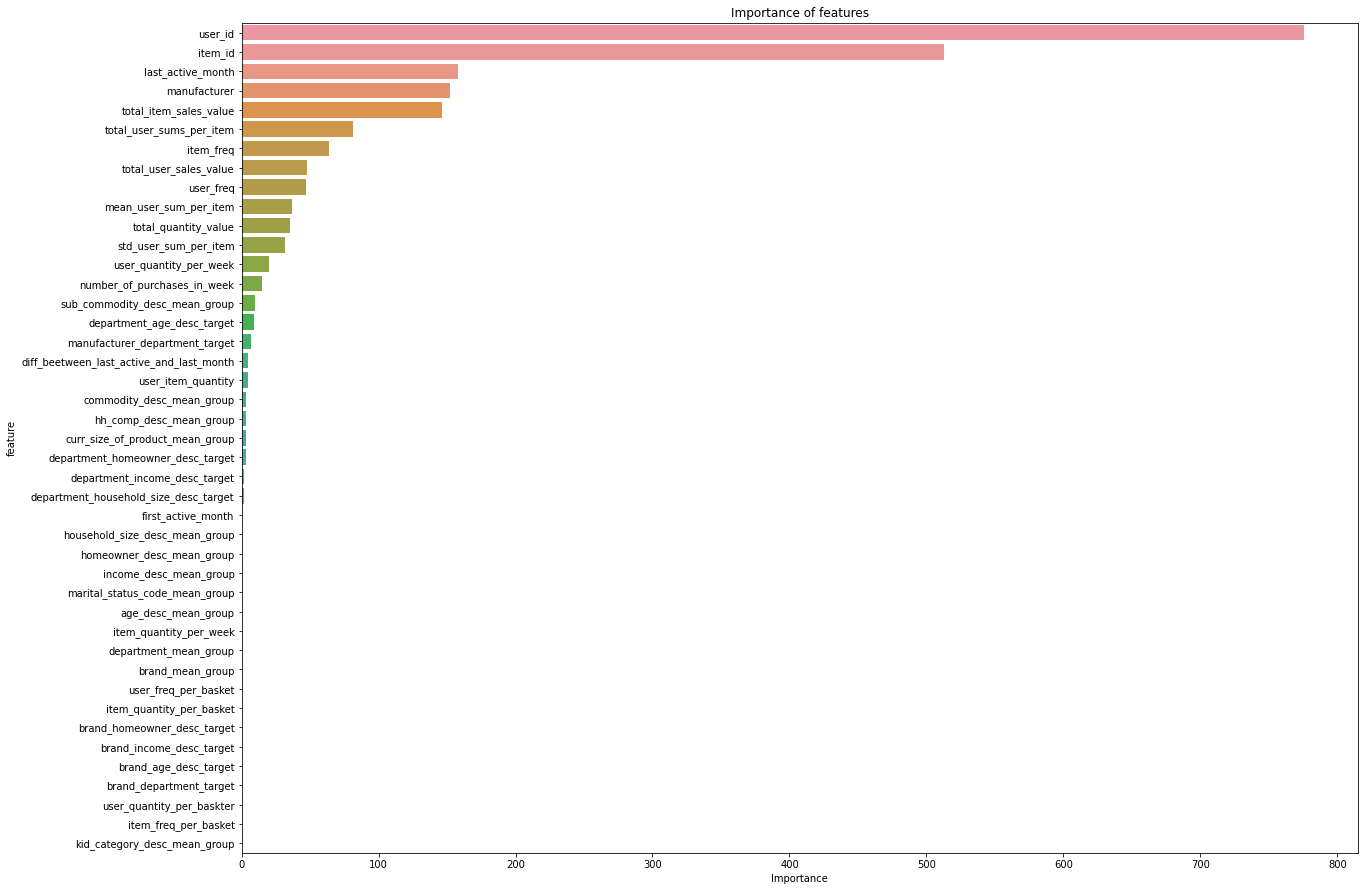

In [67]:
important_features_top = show_feature_importances(X_train.columns, lgb.feature_importances_, get_top=30)

In [68]:
train_preds = lgb.predict_proba(X_train)

In [69]:
df_ranker_predict = df_ranker_train.copy()

In [70]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [71]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [72]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.61 s, sys: 81.6 ms, total: 5.69 s
Wall time: 5.67 s


In [73]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1581372549019591)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [74]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [75]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

## Проверьте данные метрики с фичами и без (PS: должен быть прирост)

In [76]:
# смотрим на метрики выше и сравниваем что с ранжированием и без, добавляем фичи и то же смотрим
# в первом приближении метрики должны расти с использованием второго этапа

print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.21994778067884888)
('own_rec', 0.1581372549019591)


/content/drive/MyDrive/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


# Оценка на тесте для выполнения курсового проекта

In [77]:
# df_transactions = pd.read_csv('../data/transaction_data.csv')

In [78]:
df_test = pd.read_csv('drive/MyDrive/retail_test1.csv')

In [79]:
df_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [80]:
data_test_ranker = df_test[df_test.user_id.isin(common_users)]

print_stats_data(data_test_ranker,'test_ranker')

test_ranker
Shape: (88665, 12) Users: 1883 Items: 20492


In [81]:
result_test = data_test_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

# Считаем precision@5 по новому тесту

In [82]:
%%time
result_test['own_rec'] = result_test[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.18 s, sys: 76.9 ms, total: 5.26 s
Wall time: 5.26 s


In [83]:
sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1361656930430157)]

In [84]:
result_test['reranked_own_rec'] = result_test[USER_COL].apply(lambda user_id: rerank(user_id))

In [85]:
print(*sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.17894144144143936)
('own_rec', 0.1361656930430157)


/content/drive/MyDrive/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
